In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

C:\Users\wjssm\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def sin(x,T=100) :
    return np.sin(2.0*np.pi*x/T)

In [3]:
def toy_problem(T=100,ampl=0.05) :
    x=np.arange(0,2*T+1)
    noise=ampl*np.random.uniform(low=-1,high=1,size=len(x))
    return sin(x)+noise

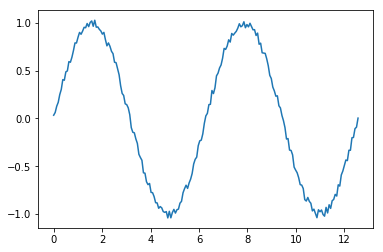

In [4]:
f=toy_problem(T=100,ampl=0.05)
x=np.arange(0,200+1)*(np.pi*4)/200
plt.plot(x,f)

In [5]:
length_of_sequence=2*100
maxlen=25

data=[]
target=[]
for i in range(0,length_of_sequence-maxlen+1) :
    data.append(f[i:(i+maxlen)])
    target.append(f[i+maxlen])

In [6]:
X=np.array(data)
X=np.array(data).reshape(len(data),maxlen,1)
y=np.array(target).reshape(len(data),1)

## Tensorflow

In [7]:
n_hidden =32
n_batch = 176

n_in = 1
n_out = 1

In [8]:
# 전체 90%를 train data
train_size = int(len(X) * 0.9)
# 10% test data
test_size = len(y) - train_size

trainX = np.array(X[0:train_size])
trainY = np.array(y[0:train_size])

testX = np.array(X[train_size:len(X)])
testY = np.array(y[train_size:len(y)])

In [9]:
x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, shape=[])

In [10]:
def inference(x,  n_batch, maxlen=None, n_hidden=None, n_in = None, n_out=None):
    def weight_variable(name1, shape1):
        return tf.get_variable(name = name1, shape = shape1,
                               initializer = tf.contrib.layers.xavier_initializer(),
                               dtype = tf.float32)
    
    def bias_variable(name1, shape1):
        return tf.get_variable(name = name1, shape = shape1,
                               initializer = tf.contrib.layers.xavier_initializer(),
                               dtype = tf.float32)
    
    state = tf.zeros( shape = (n_batch, n_hidden)) #initial hidden layer h_t-1
    c = tf.zeros( shape = (n_batch, n_hidden)) #initial cell c_t-1
    
    outputs = []
    
    #LSTM Variables
    Wxa = weight_variable('Wxa', (n_in, n_hidden))
    Wha = weight_variable('Wha', (n_hidden, n_hidden))
    Wx_input = weight_variable('Wx_input', (n_in, n_hidden))
    Wh_input = weight_variable('Wh_input', (n_hidden, n_hidden))
    Wx_output = weight_variable('Wx_output', (n_in, n_hidden))
    Wh_output = weight_variable('Wh_output', (n_hidden, n_hidden))
    Wxc = weight_variable('Wxc', (n_in, n_hidden))
    Whc = weight_variable('Whc', (n_hidden, n_hidden))
    
    ba = bias_variable('ba', (1, n_hidden))
    bi = bias_variable('bi', (1, n_hidden))
    bo = bias_variable('bo', (1, n_hidden))
    bc = bias_variable('bc', (1, n_hidden))
    
    for t in range(maxlen):
        f = tf.sigmoid( tf.matmul(x[:, t, :], Wxa) + tf.matmul(state, Wha) + ba)
        i = tf.sigmoid( tf.matmul(x[:, t, :], Wx_input) + tf.matmul(state, Wh_input) + bi)
        o = tf.sigmoid( tf.matmul(x[:, t, :], Wx_output) + tf.matmul(state, Wh_output) + bo)
        
        c = tf.multiply(c, f) + tf.multiply(i, tf.tanh(tf.matmul(x[:, t, :], Wxc) + tf.matmul(state, Whc) + bc))
        state = tf.multiply(tf.tanh(c), o)
        outputs.append(state)
    
    #Output
    output = outputs[-1] #마지막 값
    
    V = weight_variable('V', (n_hidden, n_out))
    out_b = bias_variable('out_b', (1, n_out))
    y = tf.matmul(output, V) + out_b
    return y

In [11]:
y = inference(x,n_batch=n_batch, maxlen=maxlen, n_hidden=n_hidden,n_in = n_in, n_out=n_out)

In [12]:
def loss(y, t):
    mse = tf.reduce_mean(tf.square(y-t))
    return mse
def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
    train_step = optimizer.minimize(loss)
    return train_step

loss = loss(y,t)
train_step = training(loss)

In [13]:
epochs = 1000
batch_size = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

n_batches = train_size // batch_size
from sklearn.utils import shuffle

In [14]:
my_loss = []
for epoch in range(epochs):
    X_, Y_ = shuffle(trainX, trainY)
    
    for i in range(n_batches):
        start = i* batch_size
        end = start + batch_size
    
    sess.run(train_step, feed_dict={
        x: X_[start:end], 
        t: Y_[start:end],
        n_batch: batch_size
    })
    
    val_loss = loss.eval(session=sess, feed_dict={
        x: testX, 
        t: testY, 
        n_batch: test_size
    })
    my_loss.append(val_loss)
    print("epoch:", epoch, "validation loss:", val_loss)

epoch: 0 validation loss: 1.6760478
epoch: 1 validation loss: 1.6086495
epoch: 2 validation loss: 1.5434855
epoch: 3 validation loss: 1.4795672
epoch: 4 validation loss: 1.4187989
epoch: 5 validation loss: 1.3600781
epoch: 6 validation loss: 1.3020695
epoch: 7 validation loss: 1.2492244
epoch: 8 validation loss: 1.1978029
epoch: 9 validation loss: 1.150006
epoch: 10 validation loss: 1.1025252
epoch: 11 validation loss: 1.0584102
epoch: 12 validation loss: 1.0145513
epoch: 13 validation loss: 0.972437
epoch: 14 validation loss: 0.930725
epoch: 15 validation loss: 0.8887946
epoch: 16 validation loss: 0.8480314
epoch: 17 validation loss: 0.8069325
epoch: 18 validation loss: 0.76440084
epoch: 19 validation loss: 0.72157735
epoch: 20 validation loss: 0.67878157
epoch: 21 validation loss: 0.63809764
epoch: 22 validation loss: 0.5977692
epoch: 23 validation loss: 0.55811095
epoch: 24 validation loss: 0.5197591
epoch: 25 validation loss: 0.48245844
epoch: 26 validation loss: 0.44590887
epoch: 

epoch: 214 validation loss: 0.0036358018
epoch: 215 validation loss: 0.003641569
epoch: 216 validation loss: 0.003442572
epoch: 217 validation loss: 0.0034046182
epoch: 218 validation loss: 0.003420447
epoch: 219 validation loss: 0.003300636
epoch: 220 validation loss: 0.0033928158
epoch: 221 validation loss: 0.0034797373
epoch: 222 validation loss: 0.0034040036
epoch: 223 validation loss: 0.0031764933
epoch: 224 validation loss: 0.0028738375
epoch: 225 validation loss: 0.0026320717
epoch: 226 validation loss: 0.0024633654
epoch: 227 validation loss: 0.0023765145
epoch: 228 validation loss: 0.0023757925
epoch: 229 validation loss: 0.0026027556
epoch: 230 validation loss: 0.0028494338
epoch: 231 validation loss: 0.0031281076
epoch: 232 validation loss: 0.0034499895
epoch: 233 validation loss: 0.0038769357
epoch: 234 validation loss: 0.004186396
epoch: 235 validation loss: 0.0045007803
epoch: 236 validation loss: 0.0049298154
epoch: 237 validation loss: 0.0048788176
epoch: 238 validation

epoch: 428 validation loss: 0.0015922727
epoch: 429 validation loss: 0.0016274444
epoch: 430 validation loss: 0.0016639025
epoch: 431 validation loss: 0.0016977901
epoch: 432 validation loss: 0.0017470712
epoch: 433 validation loss: 0.0017768466
epoch: 434 validation loss: 0.0018609518
epoch: 435 validation loss: 0.0019180098
epoch: 436 validation loss: 0.0019481203
epoch: 437 validation loss: 0.001982863
epoch: 438 validation loss: 0.002015717
epoch: 439 validation loss: 0.0020119795
epoch: 440 validation loss: 0.002000988
epoch: 441 validation loss: 0.001916569
epoch: 442 validation loss: 0.0019520769
epoch: 443 validation loss: 0.0019753105
epoch: 444 validation loss: 0.0018517708
epoch: 445 validation loss: 0.0016908868
epoch: 446 validation loss: 0.0015953295
epoch: 447 validation loss: 0.0015695425
epoch: 448 validation loss: 0.0015858498
epoch: 449 validation loss: 0.0015961316
epoch: 450 validation loss: 0.0015823634
epoch: 451 validation loss: 0.0015335293
epoch: 452 validatio

epoch: 641 validation loss: 0.0013259926
epoch: 642 validation loss: 0.0015199217
epoch: 643 validation loss: 0.0016741083
epoch: 644 validation loss: 0.0017438635
epoch: 645 validation loss: 0.0017229271
epoch: 646 validation loss: 0.0015919653
epoch: 647 validation loss: 0.0015004791
epoch: 648 validation loss: 0.0013639836
epoch: 649 validation loss: 0.0012872402
epoch: 650 validation loss: 0.001348946
epoch: 651 validation loss: 0.0014738459
epoch: 652 validation loss: 0.0015148424
epoch: 653 validation loss: 0.0015207098
epoch: 654 validation loss: 0.00144039
epoch: 655 validation loss: 0.001338353
epoch: 656 validation loss: 0.0013336054
epoch: 657 validation loss: 0.0014475038
epoch: 658 validation loss: 0.0016260443
epoch: 659 validation loss: 0.0018882629
epoch: 660 validation loss: 0.002154599
epoch: 661 validation loss: 0.0024034316
epoch: 662 validation loss: 0.0023952196
epoch: 663 validation loss: 0.0020887037
epoch: 664 validation loss: 0.0017397449
epoch: 665 validation

epoch: 853 validation loss: 0.0016494577
epoch: 854 validation loss: 0.0016620478
epoch: 855 validation loss: 0.0016664546
epoch: 856 validation loss: 0.0016892776
epoch: 857 validation loss: 0.0017652855
epoch: 858 validation loss: 0.0016978483
epoch: 859 validation loss: 0.0015767957
epoch: 860 validation loss: 0.0014360297
epoch: 861 validation loss: 0.0013881999
epoch: 862 validation loss: 0.001490958
epoch: 863 validation loss: 0.0016328312
epoch: 864 validation loss: 0.0017433922
epoch: 865 validation loss: 0.0017950272
epoch: 866 validation loss: 0.0016983162
epoch: 867 validation loss: 0.001680853
epoch: 868 validation loss: 0.0016741424
epoch: 869 validation loss: 0.0017123201
epoch: 870 validation loss: 0.0016627442
epoch: 871 validation loss: 0.0016084929
epoch: 872 validation loss: 0.0015535785
epoch: 873 validation loss: 0.0014967773
epoch: 874 validation loss: 0.0015566222
epoch: 875 validation loss: 0.0014694725
epoch: 876 validation loss: 0.0013432973
epoch: 877 validat

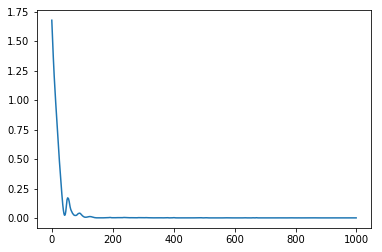

In [15]:
plt.plot(my_loss)

In [16]:
Z=X[:1]

In [17]:
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

In [18]:
for i in range(length_of_sequence - maxlen +1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict={
        x: Z[-1:], 
        n_batch: 1
    })
    
    sequence_ = np.concatenate(
        (z_.reshape(maxlen, n_in)[1:], y_), axis=0).reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

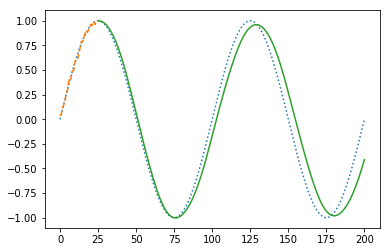

In [19]:
plt.plot(toy_problem(100, ampl=0), linestyle="dotted")
plt.plot(original, linestyle="dashed")
plt.plot(predicted)